In [1]:
from mosaic_maker import make_mosaic
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
import torch
from torchvision import transforms
from PIL import Image
from torchinfo import summary
import math
import matplotlib.pyplot as plt

model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
model.eval()

features = {}

def get_features(name):
    def hook(model, input, output):
        features[name] = output.detach()
    return hook

model.avgpool.register_forward_hook(get_features('feats'))

preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def get_outputs(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    input_image = Image.fromarray(img)
    input_tensor = preprocess(input_image)
    input_batch = input_tensor.unsqueeze(0)
    with torch.no_grad():
        output = model(input_batch)

    return features['feats'].squeeze()



/Users/paul/Library/Python/3.8/lib/python/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: dlopen(/Users/paul/Library/Python/3.8/lib/python/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libpng16.16.dylib
  Referenced from: /Users/paul/Library/Python/3.8/lib/python/site-packages/torchvision/image.so
  Reason: tried: '/usr/local/lib/libpng16.16.dylib' (no such file), '/usr/lib/libpng16.16.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")
Using cache found in /Users/paul/.cache/torch/hub/pytorch_vision_v0.10.0


In [2]:
print(model.avgpool)

AdaptiveAvgPool2d(output_size=(1, 1))


In [3]:
def add_grid(image, n_tiles, width):
    w, l = image.shape[0], image.shape[1]
    tile_size = min(w//n_tiles, l//n_tiles)
    n_tiles_w = w//tile_size
    n_tiles_l = l//tile_size

    for i in range(n_tiles_w):
        image[i*tile_size:i*tile_size+width, :, :] = 0
    
    for i in range(n_tiles_l):
        image[:, i*tile_size:i*tile_size+width, :] = 0

def resize(mosaic, size):
    w, l = mosaic.shape[0], mosaic.shape[1]
    if w<l:
        ratio = size/w
    else:
        ratio = size/l
    
    l = int(ratio*l)
    w = int(ratio*w)
    
    mosaic2 = cv2.resize(mosaic, (w,l), interpolation=cv2.INTER_AREA)
    return mosaic2

def evaluate_mosaic(mosaic, image, n_tiles):

    #mosaic = resize(mosaic, 512.5)
    #image = resize(image, 512.5)

    mosaic_blurred = cv2.medianBlur(mosaic, 3)
    image_blurred = cv2.medianBlur(image, 3)

    #add_grid(mosaic_blurred, n_tiles, 128//n_tiles)
    #add_grid(image_blurred, n_tiles, 128//n_tiles)
    cv2.imwrite('grid.jpeg', mosaic_blurred)

    dist = ssim(mosaic_blurred, image_blurred,channel_axis=2)
    dist2 = 1 - np.mean(np.abs(image_blurred-mosaic_blurred))/(256)

    return (1*dist+dist2)/2


In [8]:
def evaluation_mixed(img, mosaic, n_tiles):
    img = cv2.imread('image2.jpeg')
    img = resize(img, 512.5)
    img = cv2.medianBlur(img,3)
    
    img_out = get_outputs(img)
    
    mosaic = resize(mosaic,512.5)

    mosaic = cv2.medianBlur(mosaic,3)
    
    eval_network = 1-torch.sum(torch.square(get_outputs(mosaic)-img_out))/800
    eval_ssim = evaluate_mosaic(mosaic, img, n_tiles)*0.5

    imp = math.exp(-n_tiles/12)
    return (1-imp)*eval_network.item() + imp*eval_ssim

In [6]:
img = cv2.imread('image2.jpeg')
img = resize(img, 512.5)
img = cv2.medianBlur(img,3)
img_out = get_outputs(img)

ssim_h, network_h, mixed_h = [], [], []

for val in range(1,65,4):
    mosaic = resize(cv2.imread(f'mosaics/gradual/{val}_10000_gradual_upsizes.jpeg'),512.5)
    mosaic = cv2.medianBlur(mosaic,3)
    
    eval_network = 1-torch.sum(torch.square(get_outputs(mosaic)-img_out))/2048
    eval_ssim = evaluate_mosaic(mosaic, img, val) * 1.3

    imp = math.exp(-val/18)
    mixed_eval = (1-imp)*eval_network.item() + imp*eval_ssim

    ssim_h.append(eval_ssim)
    network_h.append(eval_network)
    mixed_h.append(mixed_eval)

    print(val, "---", imp, '---', eval_network.item(), eval_ssim, mixed_eval)


1 --- 0.9459594689067654 --- 0.7443568706512451 0.48722776303447957 0.501123156569619
5 --- 0.7574651283969664 --- 0.7656426429748535 0.702340446986859 0.7176934369629973
9 --- 0.6065306597126334 --- 0.764330267906189 0.6944025506885259 0.7219169634499613
13 --- 0.4856717852477124 --- 0.7593953609466553 0.7147460310718247 0.7377104411962323
17 --- 0.3888955639892229 --- 0.7584894299507141 0.6690315652246136 0.7236996631947856
21 --- 0.3114032239145977 --- 0.7179912328720093 0.6546267644472705 0.698259333122911
25 --- 0.24935220877729622 --- 0.7445176839828491 0.6521657231862904 0.7214895185733129
29 --- 0.19966564006790186 --- 0.779197096824646 0.6851872992661674 0.7604265704224784
33 --- 0.1598797460796939 --- 0.8152216076850891 0.769360187225681 0.8078892954271848
37 --- 0.12802169265485286 --- 0.8313909769058228 0.6651600098950949 0.8101098071374564
41 --- 0.10251175769346066 --- 0.8480157852172852 0.674200369499658 0.8301976614378517
45 --- 0.0820849986238988 --- 0.8973819613456726

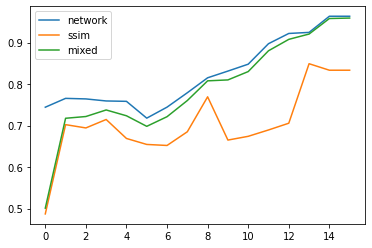

In [7]:
ax = plt.plot(network_h, label='network')
plt.plot(ssim_h, label='ssim')
plt.plot(mixed_h, label='mixed')
plt.legend()

Using cache found in /Users/paul/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /Users/paul/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /Users/paul/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /Users/paul/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /Users/paul/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /Users/paul/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /Users/paul/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /Users/paul/.cache/torch/hub/pytorch_vision_v0.10.0


[0.792581000766776, 0.7632107521680191, 0.7954788207958071, 0.7945177555084217, 0.7835795879364014, 0.800316572189331, 0.8091274499893188, 0.7986041903495789]


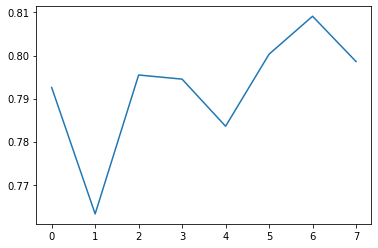

In [5]:
import pickle
from mosaic_evaluators import network_evaluation, ssim_evaluation, mixed_evaluation


image = cv2.imread('image2.jpeg')
losses = []

for i in range(100,801,100):
    mosaic = cv2.imread(f"mosaics/datalimit/32_{i}_datalimit_upsize.jpeg")
    losses.append(mixed_evaluation(image, mosaic, i))



loss3 = losses
print(loss3)
plt.plot(loss3)

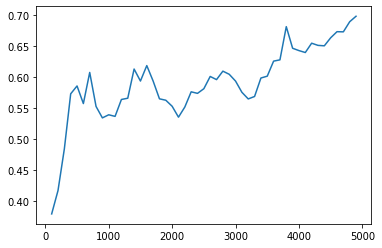

In [8]:
import pickle
import matplotlib.pyplot as plt

with open('losses.pkl', 'rb') as f:
    losses = pickle.load(f)

plt.plot(list(range(100,5000,100)), losses)
plt.savefig('eval_with_limit')